# Dual Weighted Reisdual Estimate

In this problem we revisit the Re-entrant Corner Problem but instead of
a classical residual estimator we use a dual weighted residual estimator.
The aim will be to refine the grid to reduce the error at a given point.

Here we will consider the classic _re-entrant corner_ problem,
\begin{align*}
-\Delta u &= f, && \text{in } \Omega, \\
u &= g, && \text{on } \partial\Omega,
\end{align*}
where the domain is given using polar coordinates,
\begin{gather*}
\Omega = \{ (r,\varphi)\colon r\in(0,1), \varphi\in(0,\Phi) \}~.
\end{gather*}
For the boundary condition $g$, we set it to the trace of the function $u$, given by
\begin{gather*}
u(r,\varphi) = r^{\frac{\pi}{\Phi}} \sin\big(\frac{\pi}{\Phi} \varphi \big)
\end{gather*}

In [1]:
import matplotlib.pyplot as pyplot
import numpy
from dune.fem.plotting import plotPointData as plot
import dune.grid as grid
import dune.fem as fem
import dune.common as common
from dune.fem.view import adaptiveLeafGridView as adaptiveGridView
from dune.fem.space import lagrange as solutionSpace
from dune.fem.scheme import galerkin as solutionScheme
from dune.alugrid import aluConformGrid as leafGridView
from dune.ufl import DirichletBC
from dune.fem.function import gridFunction
from dune.fem import GridMarker

from ufl import *
try: # this is needed to remain compatible with version 2022 of ufl
    from ufl import atan_2 as atan2
except:
    pass

# set the angle for the corner (0<angle<=360)
cornerAngle = 320.

# use a second order space
order = 2

We first define the domain and set up the grid and space.
We need this twice - once for a computation on a globally refined grid
and once for an adaptive one so we put the setup into a function:

We first define the grid for this domain (vertices are the origin and 4
equally spaced points on the unit sphere starting with (1,0) and
ending at (cos(cornerAngle), sin(cornerAngle))

Next we define the model together with the exact solution.

In [2]:
def setup():
    vertices = numpy.zeros((8, 2))
    vertices[0] = [0, 0]
    for i in range(0, 7):
        vertices[i+1] = [numpy.cos(cornerAngle/6*numpy.pi/180*i),
                         numpy.sin(cornerAngle/6*numpy.pi/180*i)]
    triangles = numpy.array([[2,1,0], [0,3,2], [4,3,0],
                             [0,5,4], [6,5,0], [0,7,6]])
    domain = {"vertices": vertices, "simplices": triangles}
    gridView = adaptiveGridView( leafGridView(domain) )
    gridView.hierarchicalGrid.globalRefine(2)
    space = solutionSpace(gridView, order=order)

    u = TrialFunction(space)
    v = TestFunction(space)
    x = SpatialCoordinate(space)

    # exact solution for this angle
    Phi = cornerAngle / 180 * pi
    phi = atan2(x[1], x[0]) + conditional(x[1] < 0, 2*pi, 0)
    exact = dot(x, x)**(pi/2/Phi) * sin(pi/Phi * phi)
    a = dot(grad(u), grad(v)) * dx

    # set up the scheme
    laplace = solutionScheme([a==0, DirichletBC(space, exact, 1)], solver="cg",
            parameters={"linear.preconditioning.method":"jacobi"})
    uh = space.interpolate(0, name="solution")
    return uh, exact, laplace

uh, exact, laplace = setup()

Now we can setup the functional which will be $J(v)=v(P)$ where
$P=(0.4,0.4)$ is some point in the computational domain at which we want
to minimize the error. To compute the dwr estimator we need the solution
to the dual problem with right hand side $J(\varphi_i)$ for all basis
functions $\varphi_i$. This is not directly expressible in UFL and we
therefore need to implement this either using some lower level functions
on the space or using a small C++ function which we then export
to Python.
Here we implement a version based entirely on the available binding,
In a [second notebook](laplace-dwr-algorithm_nb.ipynb) we revisit this problem
but implement a version using some C++ code to speed up the evaluation of the functional.

In [3]:

spaceZ = solutionSpace(uh.space.gridView, order=order+1)
u = TrialFunction(spaceZ)
v = TestFunction(spaceZ)
x = SpatialCoordinate(spaceZ)
a = dot(grad(u), grad(v)) * dx
dual = solutionScheme([a==0,DirichletBC(spaceZ,0)], solver="cg")
z = spaceZ.interpolate(0, name="dual")
zh = uh.copy(name="dual_h")
point = common.FieldVector([0.4,0.4])
pointFunctional = z.copy("dual_rhs")
eh = gridFunction(abs(exact-uh),name="error", order=order+1)

from dune.fem.utility import pointSample
def computeFunctional(point, pointFunctional, eh):
    space = pointFunctional.space
    en, xLoc = pointSample(space.gridView, point)
    phiVal = numpy.array( space.evaluateBasis(en, xLoc) )[:,0] # issue here with scalar function spaces
    idx = space.mapper()(en)
    lf = eh.localFunction()
    lf.bind(en)
    pointFunctional.as_numpy[ idx ] += phiVal
    return lf(xLoc)

Next we define the actual estimator:

In [4]:
from dune.fem.space import finiteVolume as estimatorSpace
from dune.fem.operator import galerkin as estimatorOp

fvspace = estimatorSpace(uh.space.gridView)
estimate = fvspace.interpolate([0], name="estimate")

u = TrialFunction(uh.space)
v = TestFunction(fvspace)
n = FacetNormal(fvspace)
estimator_ufl = abs(div(grad(u)))*abs(z-zh) * v * dx +\
                abs(inner(jump(grad(u)), n('+')))*abs(avg(z-zh)) * avg(v) * dS
estimator = estimatorOp(estimator_ufl)

Let us solve over a loop (solve,estimate,mark) and plot the solutions side by side.

In [5]:
h1error = dot(grad(uh - exact), grad(uh - exact))

def compute(tolerance, fig):
    count = 0
    errorVector    = []
    estimateVector = []
    dofs           = []

    hTol = 1.
    marker = GridMarker( estimate, lambda : hTol )

    while True:
        laplace.solve(target=uh)
        if count == 10:
            plot(uh, figure=(fig, 121), colorbar=False, linewidth=1)
        pointFunctional.clear()
        error = computeFunctional(point, pointFunctional,eh)
        dual.solve(target=z, rightHandSide=pointFunctional)
        zh.interpolate(z)
        estimator(uh, estimate)
        eta = sum(estimate.dofVector)
        dofs           += [uh.space.size]
        errorVector    += [error]
        estimateVector += [eta]
        if eta < tolerance:
            break
        # update refinement tolerance
        hTol = eta/uh.space.gridView.size(0)
        fem.gridAdapt(marker, uh) # can also be a list or tuple of function to prolong/restrict
        fem.loadBalance(uh)
        count += 1
    plot(uh, figure=(fig, 122), colorbar=False, linewidth=1)
    return dofs, estimateVector, errorVector

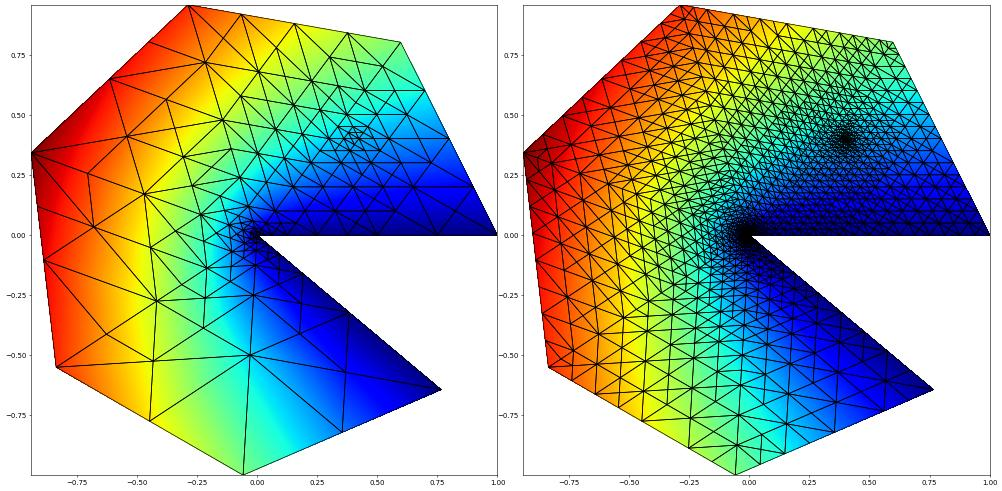

In [6]:
fig = pyplot.figure(figsize=(20,10))
dofs, estimateVector, errorVector = compute( tolerance=1e-6, fig=fig )

Here is a table with the number of dofs, the estimated, and actual error:

In [7]:
try:
    import pandas as pd
    keys = {'dofs': dofs, 'estimate': estimateVector, "error": errorVector}
    table = pd.DataFrame(keys, index=range(len(dofs)),columns=['dofs', 'estimate', 'error'])
    print(table)
except ImportError:
    print("pandas module not found so not showing table - ignored")
    pass

pandas module not found so not showing table - ignored


Let's take a close up look of the refined region around the point of
interest and the origin:

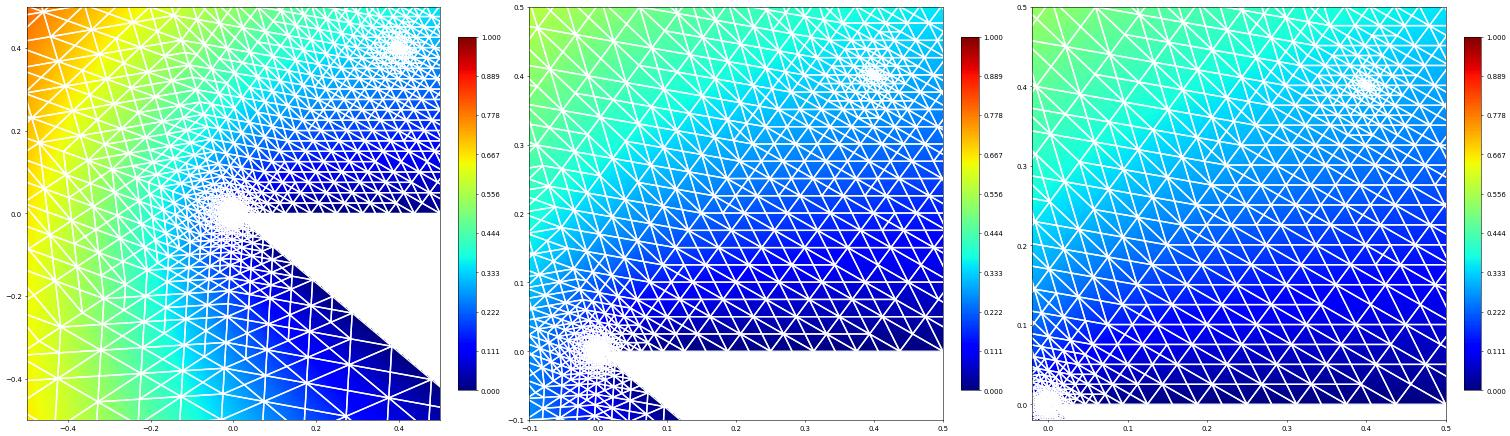

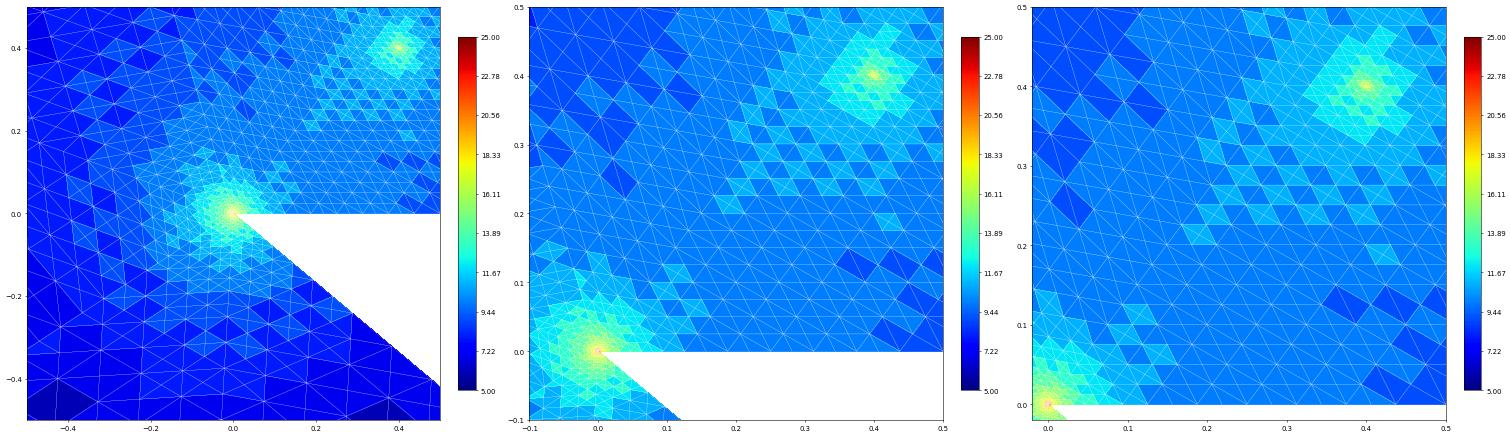

In [8]:
pyplot.close('all')
fig = pyplot.figure(figsize=(30,10))
plot(uh, figure=(fig, 131), xlim=(-0.5, 0.5), ylim=(-0.5, 0.5),
        gridLines="white", colorbar={"shrink": 0.75}, linewidth=2)
plot(uh, figure=(fig, 132), xlim=(-0.1, 0.5), ylim=(-0.1, 0.5),
        gridLines="white", colorbar={"shrink": 0.75}, linewidth=2)
plot(uh, figure=(fig, 133), xlim=(-0.02, 0.5), ylim=(-0.02, 0.5),
        gridLines="white", colorbar={"shrink": 0.75}, linewidth=2)

fig = pyplot.figure(figsize=(30,10))
from dune.fem.function import levelFunction
levels = levelFunction(uh.space.gridView)
plot(levels, figure=(fig, 131), xlim=(-0.5, 0.5), ylim=(-0.5, 0.5),
        gridLines="white", colorbar={"shrink": 0.75})
plot(levels, figure=(fig, 132), xlim=(-0.1, 0.5), ylim=(-0.1, 0.5),
        gridLines="white", colorbar={"shrink": 0.75})
plot(levels, figure=(fig, 133), xlim=(-0.02, 0.5), ylim=(-0.02, 0.5),
        gridLines="white", colorbar={"shrink": 0.75})